## Pre-coding stuff

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
! pip install transformers==4.5.1 datasets sentencepiece syllables shap bertviz captum huggingface_hub
! python -m spacy download de_core_news_sm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Promotion/text_complexity/')

## Explain Distilbert final

In [ ]:
from transformers import DistilBertModel, AutoTokenizer, DistilBertForSequenceClassification

distilbert_path = '/content/drive/MyDrive/Promotion/text_complexity/models/distilbert_final'
base_model_string = "distilbert-base-german-cased"
pretrained = DistilBertForSequenceClassification.from_pretrained(distilbert_path)

Downloading:   0%|          | 0.00/674 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/270M [00:00<?, ?B/s]

In [ ]:
text_cols = 'Sentence'
# The label col is expected to contain integers from 0 to N_classes - 1
label_col = 'MOS' 
numerical_cols = ['perc_syl_3', 'avg_sent_len', 'perc_word_6', 'perc_syl_1', 
                  'avg_syl_count', 'tree_depth', 'fre_amstad', 'SMOG', 'wstf_1', 
                  'wstf_2', 'wstf_3', 'wstf_4']
seq_max_len = 99

tokenizer = AutoTokenizer.from_pretrained(base_model_string)

Downloading:   0%|          | 0.00/464 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/240k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/479k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

In [ ]:
test_sentences = [
    "Das ist ein Satz.",
    "Dieses Eisenoxid resultierte in großen Ablagerungen so genannter Bändererze, die als ergiebige Lagerstätten erhalten blieben und intensiv abgebaut werden.",
    "Das ist unsere Donauschifffahrtsgemeinschaft.",
    "Diese vollständige Wiederverwertung ist Basis der Subsistenzwirtschaft.",
    "In diesem Fall nennt man den Würfel gezinkt.",
    "Der Ursprung der älteren Gesteine des Parks sind klastische Sedimentgesteine.",
    "Eine Unterteilung wird gleichfalls nach standortbedingter Bauform vorgenommen."
  ]
targets = [
    1.0,
    5.166667,
    2.5,
    3.454545,
    3.625,
    3.2857,
    3.44444
]

In [ ]:
test_sentences = list(tr_dat.sample(7).Sentence.values) + ["Eine Unterteilung wird gleichfalls nach standortbedingter Bauform vorgenommen."]
test_sentences

['Erst nachdem die Dänen infolge Berücksichtigung gewisser Sonderinteressen (ua Nichtbeteiligung an der Währungsunion) in einer zweiten Volksabstimmung den Maastrichter Vertrag hatten passieren lassen und das deutsche Bundesverfassungsgericht Klagen gegen die Übertragung von Souveränitätsrechten auf die EU als – im gegebenen Rahmen – grundgesetzkonform zurückgewiesen hatte, konnte er zum 1 November 1993 in Kraft treten.',
 'Das Erscheinungsbild des Nationalparks prägen die quer zum Hauptkamm verlaufenden von eiszeitlichen Gletschern ausgeschliffenen Trogtäler mit über 750 Seen, von denen nur 131 einen offiziellen Namen tragen.',
 'Das heiße Fluid kann zur Bereitstellung von Industriedampf und zur Speisung von Nah- und Fernwärmenetzen genutzt werden.',
 'Weil diese Arten oft die Basis der Nahrungsketten in den Ozeanen bilden, können sich daraus weitere schwerwiegende Konsequenzen für die zahlreichen von ihnen abhängigen Meeresbewohner und in der Folge auch für die auf diese angewiesenen

In [ ]:
from transformers import Trainer, TrainingArguments
feature_trainer = Trainer(model=pretrained, args=TrainingArguments('models/feature_trainer', num_train_epochs=2), tokenizer=tokenizer)

In [ ]:
from utils import load_data_and_statistics
import torch
import numpy as np
import pandas as pd

class TextComplexityDataset(torch.utils.data.Dataset):
  def __init__(self, encodings, df, numerical_feats, labels_col):
    self.df = df
    self.encodings = encodings
    self.numerical_feats = np.array(df[numerical_feats]) 
    self.labels = df[labels_col].values if labels_col is not None else torch.zeros(len(df))
  
  def __getitem__(self, idx):
    item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    #item['labels'] = torch.tensor(self.labels[idx]) if self.labels is not None  else None
    #item['numerical_feats'] = torch.tensor(self.numerical_feats[idx]).float()\
    #    if self.numerical_feats is not None else torch.zeros(0)
    return item

  def __get_labels__(self):
    return self.labels
  
  def __len__(self):
    return len(self.df)

def predict_example(test_sentences):
  df_example = pd.DataFrame(test_sentences, columns=['Sentence'])
  df_example = load_data_and_statistics(df_example, from_file=False)
  tok_example = tokenizer(list(df_example[text_cols]), padding='max_length', truncation=True, max_length=seq_max_len)
  data_example = TextComplexityDataset(tok_example, df_example, numerical_cols, None)
  preds = feature_trainer.predict(test_dataset=data_example)
  return preds[0]
predict_example(test_sentences)

In [ ]:
training_data_path = '/content/drive/MyDrive/Promotion/text_complexity/public_data_text_complexity22/training_set_balanced.csv'
tr_dat = load_data_and_statistics(training_data_path)

In [ ]:
tr_dat[tr_dat.Sentence.isin(test_sentences)].drop_duplicates()

,index,sentence_id,Sentence,MOS,tree_depth,fre_amstad,SMOG,perc_syl_3,avg_sent_len,perc_word_6,perc_syl_1,avg_syl_count,wstf_1,wstf_2,wstf_3,wstf_4
3,346,399,Weil diese Arten oft die Basis der Nahrungsket...,5.555556,8,24.418919,6.427356,0.270270,37,0.297297,0.459459,2.027027,5.387232,3.539462,6.014181,8.208362
39,851,964,Erst nachdem die Dänen infolge Berücksichtigun...,4.812500,13,-8.125000,7.301100,0.307692,52,0.384615,0.423077,2.326923,7.914988,6.081962,8.882769,12.202631
202,873,986,Dieser Kirchengemeinde gehörten auch alle nach...,1.900000,3,3.812500,5.215100,0.500000,8,0.500000,0.250000,2.875000,0.616025,-1.264400,0.557750,0.569000
215,377,433,Dieser Vorgang wird Gletscherschwund oder Glet...,2.266667,4,39.285714,4.604125,0.285714,7,0.571429,0.142857,2.285714,0.420129,-1.465800,0.303757,0.244600
318,493,563,Das heiße Fluid kann zur Bereitstellung von In...,3.200000,11,56.323529,4.935629,0.176471,17,0.294118,0.588235,1.823529,2.020459,0.156200,2.176388,2.870624
414,524,596,Das Erscheinungsbild des Nationalparks prägen ...,5.555556,6,31.666667,5.888619,0.259259,27,0.333333,0.444444,2.074074,3.718267,1.860200,4.105919,5.549341
612,102,123,Eine Unterteilung wird gleichfalls nach stando...,3.444444,5,25.750000,4.935629,0.375000,8,0.625000,0.375000,2.500000,0.603962,-1.272325,0.520712,0.534700
960,187,225,Um laute Aufprallgeräusche und ein Wegrollen d...,4.500000,8,30.363636,6.079149,0.363636,22,0.454545,0.409091,2.181818,2.919341,1.056791,3.184345,4.249982


In [ ]:
complex_sents = tr_dat[tr_dat.MOS > 3.0]['Sentence'].values
lens = np.array(list(map(lambda x: len(x), complex_sents)))
tr_sample = tr_dat[tr_dat.Sentence.isin(complex_sents[lens < 80])]
#print(predict_example(tr_sample.Sentence.values))
#tr_sample

In [ ]:
tr_dat[tr_dat.Sentence == "Martin Luther King Jr (* 15 Januar 1929 in Atlanta als Michael King Jr; † 4 April 1968 in Memphis) war ein US-amerikanischer Baptistenpastor und Bürgerrechtler."]

,index,sentence_id,Sentence,MOS,tree_depth,fre_amstad,SMOG,perc_syl_3,avg_sent_len,perc_word_6,perc_syl_1,avg_syl_count,wstf_1,wstf_2,wstf_3,wstf_4
894,863,976,Martin Luther King Jr (* 15 Januar 1929 in Atl...,1.0,4,49.7,5.2151,0.16,25,0.24,0.6,1.8,3.347468,1.491064,3.695508,4.990904


## SHAP

In [ ]:
import shap

explainer = shap.Explainer(predict_example, tokenizer)

In [ ]:
shap_values = explainer(test_sentences)

In [ ]:
for shap_val in shap_values:
  shap.plots.text(shap_val)

In [ ]:
with open('shap_example_distilbert.html', 'w+') as f:
  f.write(shap.plots.text(shap_values[-2], display=False))
#plt.savefig('shap_example_distilbert.pdf')
shap.plots.text(shap_values[-2])

## BERTViz

In [ ]:
from transformers import AutoTokenizer, AutoModel, utils
from bertviz import model_view
utils.logging.set_verbosity_error()  # Suppress standard warnings

input_text = "Das ist ein einfacher Satz."  
model = AutoModel.from_pretrained(distilbert_path, output_attentions=True)  # Configure model to return attention values
tokenizer = AutoTokenizer.from_pretrained(base_model_string)
inputs = tokenizer.encode(input_text, return_tensors='pt')  # Tokenize input text
outputs = model(inputs)  # Run model
attention = outputs[-1]  # Retrieve attention from model outputs
tokens = tokenizer.convert_ids_to_tokens(inputs[0])  # Convert input ids to token strings
model_view(attention, tokens)

<IPython.core.display.Javascript object>

In [ ]:
from bertviz.transformers_neuron_view import BertModel, BertTokenizer
from bertviz.neuron_view import show

model_type = 'bert'
model = BertModel.from_pretrained(distilbert_path, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained('bert-base-german-cased', do_lower_case=False)
show(model, model_type, tokenizer, input_text, input_text, layer=4, head=3)

## Captum.ai

In [ ]:
import torch
device = 'cpu'
def predict(inputs, attention_mask=None):
    output = pretrained(inputs, attention_mask=attention_mask, )
    return output

def custom_forward(inputs, attention_mask=None, position=0):
    outputs = predict(inputs, attention_mask=attention_mask)
    preds = outputs[0]
    return preds

def construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id):

    text_ids = tokenizer.encode(text, add_special_tokens=False)
    # construct input token ids
    input_ids = [cls_token_id] + text_ids + [sep_token_id]
    # construct reference token ids 
    ref_input_ids = [cls_token_id] + [ref_token_id] * len(text_ids) + [sep_token_id]

    return torch.tensor([input_ids], device=device), torch.tensor([ref_input_ids], device=device), len(text_ids)

def construct_input_ref_token_type_pair(input_ids, sep_ind=0):
    seq_len = input_ids.size(1)
    token_type_ids = torch.tensor([[0 if i <= sep_ind else 1 for i in range(seq_len)]], device=device)
    ref_token_type_ids = torch.zeros_like(token_type_ids, device=device)# * -1
    return token_type_ids, ref_token_type_ids

def construct_input_ref_pos_id_pair(input_ids):
    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype=torch.long, device=device)
    # we could potentially also use random permutation with `torch.randperm(seq_length, device=device)`
    ref_position_ids = torch.zeros(seq_length, dtype=torch.long, device=device)

    position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
    ref_position_ids = ref_position_ids.unsqueeze(0).expand_as(input_ids)
    return position_ids, ref_position_ids
    
def construct_attention_mask(input_ids):
    return torch.ones_like(input_ids)

def construct_whole_bert_embeddings(input_ids, ref_input_ids, \
                                    token_type_ids=None, ref_token_type_ids=None, \
                                    position_ids=None, ref_position_ids=None):
    input_embeddings = pretrained.distilbert.embeddings(input_ids)
    ref_input_embeddings = pretrained.distilbert.embeddings(ref_input_ids)
    
    return input_embeddings, ref_input_embeddings

In [ ]:
tok_example = tokenizer(list(test_sentences[-2]), padding='max_length', truncation=True, max_length=seq_max_len, return_tensors='pt')
custom_forward(inputs=tok_example['input_ids'], attention_mask=tok_example['attention_mask'])

In [ ]:
def join_word_tokens(scores, words):
  map = [x.startswith('##') for x in words]
  merged = []
  for i, (inner, word, score) in enumerate(zip(map, words, scores)):
    #print(i, inner, word, score)
    if word.startswith('##'):
      merged[-1] += score
    else:
      merged.append(score)

  sent = ' '.join(words)
  sent = sent.replace(' ##', '')
  return torch.tensor(merged), sent.split(' ')

In [ ]:
ref_token_id = tokenizer.pad_token_id # A token used for generating token reference
sep_token_id = tokenizer.sep_token_id # A token used as a separator between question and text and it is also added to the end of the text.
cls_token_id = tokenizer.cls_token_id # A token used for prepending to the concatenated question-text word sequence

sent_id = -2
text = test_sentences[sent_id]
input_ids, ref_input_ids, sep_id = construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id)
token_type_ids, ref_token_type_ids = construct_input_ref_token_type_pair(input_ids, sep_id)
position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
attention_mask = construct_attention_mask(input_ids)

indices = input_ids[0].detach().tolist()
all_tokens = tokenizer.convert_ids_to_tokens(indices)

In [ ]:
from captum.attr import LayerIntegratedGradients
lig = LayerIntegratedGradients(custom_forward, getattr(pretrained, 'distilbert').embeddings)
attributions, delta = lig.attribute(inputs=input_ids,
                                  baselines=ref_input_ids,
                                  additional_forward_args=(attention_mask, 0),
                                  return_convergence_delta=True)

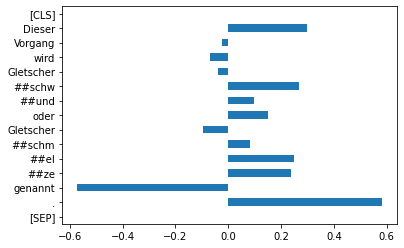

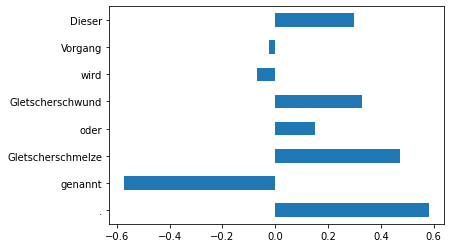

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def bar_plot_scores(remove_special=False, join_words=False):
  attr_sum = attributions.sum(-1)[0]
  attr = (attr_sum / torch.norm(attr_sum))
  if remove_special:
    detok = tokenizer.convert_ids_to_tokens(input_ids.detach().numpy()[0], skip_special_tokens=remove_special)
    attr = np.array(attr)[1:-1]
  else:
    detok = tokenizer.convert_ids_to_tokens(input_ids.detach().numpy()[0])

  if join_words:
    attr, detok = join_word_tokens(attr, detok)

  attr = torch.flip(attr, [0])
  detok = np.flip(detok)
  a = pd.Series(np.array(attr), index=detok)
  plt.show(a.plot.barh())

bar_plot_scores()
bar_plot_scores(True, True)

In [ ]:
def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    return attributions

def get_topk_attributed_tokens(attrs, k=5):
    values, indices = torch.topk(attrs, k)
    top_tokens = [all_tokens[idx] for idx in indices]
    return top_tokens, values, indices

print(pretrained.distilbert.embeddings)

lig2 = LayerIntegratedGradients(custom_forward, \
                                [pretrained.distilbert.embeddings.word_embeddings, \
                                 pretrained.distilbert.embeddings.position_embeddings])

attributions_start = lig2.attribute(inputs=input_ids,
                                  baselines=ref_input_ids,
                                  additional_forward_args=(attention_mask, 0))

attributions_start_word = summarize_attributions(attributions_start[0])

attributions_start_position = summarize_attributions(attributions_start[1])

Embeddings(
  (word_embeddings): Embedding(31102, 768, padding_idx=0)
  (position_embeddings): Embedding(512, 768)
  (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)


Multiple layers provided. Please ensure that each layer is**not** solely solely dependent on the outputs ofanother layer. Please refer to the documentation for moredetail.


In [ ]:
top_words_start, top_words_val_start, top_word_ind_start = get_topk_attributed_tokens(attributions_start_word)

top_pos_start, top_pos_val_start, pos_ind_start = get_topk_attributed_tokens(attributions_start_position)

df_start = pd.DataFrame({'Word(Index), Attribution': ["{} ({}), {}".format(word, pos, round(val.item(),2)) for word, pos, val in zip(top_words_start, top_word_ind_start, top_words_val_start)],
                   'Position(Index), Attribution': ["{} ({}), {}".format(position, pos, round(val.item(),2)) for position, pos, val in zip(top_pos_start, pos_ind_start, top_pos_val_start)]})
df_start.style.apply(['cell_ids: False'])

['{}({})'.format(token, str(i)) for i, token in enumerate(all_tokens)]

['[CLS](0)',
 'Dieser(1)',
 'Vorgang(2)',
 'wird(3)',
 'Gletscher(4)',
 '##schw(5)',
 '##und(6)',
 'oder(7)',
 'Gletscher(8)',
 '##schm(9)',
 '##el(10)',
 '##ze(11)',
 'genannt(12)',
 '.(13)',
 '[SEP](14)']

In [ ]:
df_start

,"Word(Index), Attribution","Position(Index), Attribution"
0,". (13), 0.71","##ze (11), nan"
1,"##ze (11), 0.36","Gletscher (8), nan"
2,"##el (10), 0.31","##schm (9), nan"
3,"##schm (9), 0.25","##el (10), nan"
4,"##schw (5), 0.24",". (13), nan"


In [ ]:
from captum.attr import LayerConductance
from tqdm import tqdm

def squad_pos_forward_func2(input_emb, attention_mask=None, position=0):
    pred = pretrained(inputs_embeds=input_emb, attention_mask=attention_mask, )
    pred = pred[position]
    return pred.max(1).values

layer_attrs_start = []

# The token that we would like to examine separately.
token_to_explain = 2 # the index of the token that we would like to examine more thoroughly
layer_attrs_start_dist = []

input_embeddings, ref_input_embeddings = construct_whole_bert_embeddings(input_ids, ref_input_ids, \
                                         token_type_ids=token_type_ids, ref_token_type_ids=ref_token_type_ids, \
                                         position_ids=position_ids, ref_position_ids=ref_position_ids)

for i in tqdm(range(pretrained.config.num_hidden_layers)):
    lc = LayerConductance(squad_pos_forward_func2, pretrained.distilbert.transformer.layer[i])
    layer_attributions_start = lc.attribute(inputs=input_embeddings, baselines=ref_input_embeddings, additional_forward_args=(attention_mask, 0))
    layer_attrs_start.append(summarize_attributions(layer_attributions_start).cpu().detach().tolist())

    # storing attributions of the token id that we would like to examine in more detail in token_to_explain
    layer_attrs_start_dist.append(layer_attributions_start[0,token_to_explain,:].cpu().detach().tolist())

100%|██████████| 6/6 [00:12<00:00,  2.09s/it]


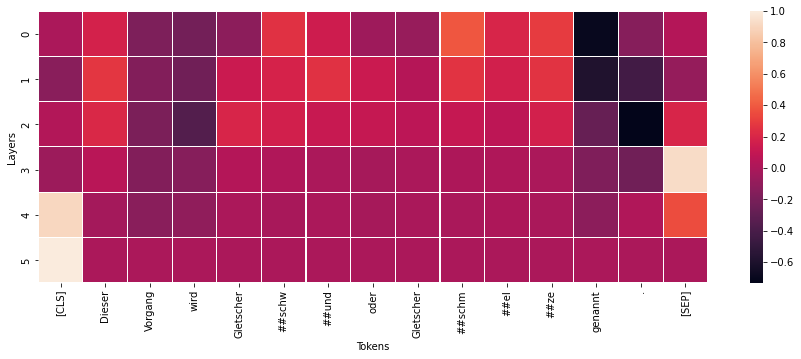

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(15,5))
xticklabels=all_tokens
yticklabels=list(range(pretrained.config.num_hidden_layers))
ax = sns.heatmap(np.array(layer_attrs_start), xticklabels=xticklabels, yticklabels=yticklabels, linewidth=0.2)
plt.xlabel('Tokens')
plt.ylabel('Layers')
plt.show()